# Sparkify - Analyze Subset Dataset
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). This workspace explores a smaller subset with Spark before deploying your cluster on the cloud. 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime

# pyspark APIs
from pyspark.sql import SparkSession

from pyspark.sql.functions import avg, count, max, min, round, sum, udf, desc, isnan, countDistinct, when, col, trim
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler
from sklearn.metrics import confusion_matrix

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
# create a Spark session
spark = (SparkSession.builder 
                    .master("local") 
                    .appName("sparkify") 
                    .getOrCreate())

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Here the dataset is loaded and cleaned, checking for invalid or missing data - for example, records without userids or sessionids. 

In [8]:
events_df = spark.read.json('mini_sparkify_event_data.json')
events_df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [9]:
events_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
print((events_df.count(), len(events_df.columns)))

(286500, 18)


In [11]:
events_df.select([count(when(isnan(c), c)).alias(c) for c in events_df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



- Drop cells for 'userId','sessionId' that have null

In [12]:
events_df = events_df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [13]:
events_df.count()

286500

- No null in the datasets, how about the empty string for the columns?

In [14]:
events_df.filter((events_df['sessionId'] == '') | events_df['sessionId'].isNull() | isnan(events_df['sessionId'])).count()

0

In [15]:
events_df.filter((events_df['userId'] == '') | events_df['userId'].isNull() | isnan(events_df['userId'])).count()

8346

In [16]:
events_df.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



- By checking out the userid column, we can confirm that there seems contain value of empty string
- Let's filter them out

In [163]:
df = events_df

In [44]:
df.filter('page = "Cancellation Confirmation"').show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [164]:
def drop_missing(column,df=df):
    missing_count = df.filter((df[column] == '') | df[column].isNull() | isnan(df[column])).count()
    print('missing count:', missing_count)
    df = df.filter(df[column].isNotNull())
    df = df.filter(df[column] != '')
#     df = df.na.drop()
#     print(df.count())
    print('Done cleaning!')
    return df

In [165]:
df = drop_missing('userId')

missing count: 8346
Done cleaning!


In [166]:
df.count()

278154

- Finally, the datasets is 278154 rows and 18 columns

# Exploratory Data Analysis
Perform EDA by loading a small subset of the data and doing basic manipulations within Spark.

In [23]:
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154
1,mean,551.0852017937219,None,None,None,114.89918174824018,None,249.11718197783722,None,None,None,None,1.535358834085557E12,1042.5616241362698,Infinity,209.10321620397335,1.5409589154318577E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.85172939949013,None,99.23517921058324,None,None,None,None,3.291321616328068E9,726.5010362219821,NaN,30.151388851327823,1.5068287123347573E9,None,109091.94999910519
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",10
4,max,ÃÂlafur Arnalds,Logged In,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


- Anyone who visit the cancellation page cancelled the subscription with Sparkify, which is churn that we are interested in. 
- Let's take a look into it. 

In [24]:
events_df.select('page').drop_duplicates().sort('page').show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [25]:
events_df.select('page').groupby('page').count().orderBy(desc('count')).toPandas()

,page,count
0,NextSong,228108
1,Home,14457
2,Thumbs Up,12551
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Login,3241
7,Logout,3226
8,Thumbs Down,2546
9,Downgrade,2055


In [26]:
events_df.select('auth').groupby('auth').count().orderBy(desc('count')).toPandas()

,auth,count
0,Logged In,278102
1,Logged Out,8249
2,Guest,97
3,Cancelled,52


### Define Churn

Once done some preliminary analysis, create a column `Churn` to use as the label for the model. `Cancellation Confirmation` events using to define your churn, which happen for both paid and free users. (a bonus task, you can also look into the `Downgrade` events.)

- We are also interested in the user ids before and after certain event. 
- For example, let's look into the user ids of cancellation process and create a column for it

In [48]:
df.filter('page = "Cancellation Confirmation"').show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [167]:
flag_cancell_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [168]:
df = df.withColumn('Churn', flag_cancell_event('page'))  # create a new column indicating the user has churned

In [169]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)

### Explore Data
perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### 1. How many songs the users (churn/not churn) listening in the particular hour 

In [170]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [171]:
df = df.withColumn('hour', get_hour(df.ts))

In [55]:
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0, hour='20'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', Churn=0, hour='20'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', l

In [172]:
songs_in_hour_0 = df.filter(df.Churn == 0).groupby(df.hour).agg({'hour':'count'}).orderBy(df.hour.cast("float"))
songs_in_hour_0.show(5)

+----+-----------+
|hour|count(hour)|
+----+-----------+
|   0|       9983|
|   1|       9908|
|   2|       9772|
|   3|       9911|
|   4|      10074|
+----+-----------+
only showing top 5 rows



In [173]:
#songs_in_hour_1 = df.filter(df.Churn == 1).groupby(df.hour).count().orderBy(df.hour.cast("float"))
songs_in_hour_1 = df.filter(df.Churn == 1).groupby(df.hour).agg({'hour':'count'}).orderBy(df.hour.cast("float"))
songs_in_hour_1.show(5)

+----+-----------+
|hour|count(hour)|
+----+-----------+
|   0|          2|
|   1|          1|
|   2|          2|
|   3|          5|
|   6|          3|
+----+-----------+
only showing top 5 rows



In [146]:
#hour_songs = songs_in_hour_1.join(songs_in_hour_0,on=['hour'], how='inner')
#hour_songs.show(5)

In [174]:
songs_in_hour_pd_0 = songs_in_hour_0.toPandas()
songs_in_hour_pd_0.hour = pd.to_numeric(songs_in_hour_pd_0.hour)
print(songs_in_hour_pd_0)

    hour  count(hour)
0      0         9983
1      1         9908
2      2         9772
3      3         9911
4      4        10074
5      5        10359
6      6        10559
7      7        11293
8      8        11644
9      9        12303
10    10        13195
11    11        13931
12    12        14253
13    13        13867
14    14        13427
15    15        13348
16    16        13214
17    17        12456
18    18        12059
19    19        11490
20    20        10817
21    21        10086
22    22        10078
23    23        10075


In [175]:
songs_in_hour_pd_1 = songs_in_hour_1.toPandas()
songs_in_hour_pd_1.hour = pd.to_numeric(songs_in_hour_pd_1.hour)
print(songs_in_hour_pd_1)

    hour  count(hour)
0      0            2
1      1            1
2      2            2
3      3            5
4      6            3
5      7            1
6      8            1
7      9            2
8     10            1
9     11            5
10    12            2
11    13            2
12    14            5
13    15            4
14    16            3
15    17            3
16    18            2
17    19            2
18    20            2
19    21            1
20    22            1
21    23            2


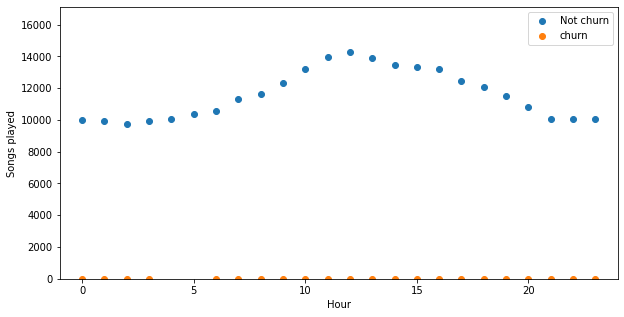

In [150]:
plt.figure(figsize =(10,5))

churn_0 = plt.scatter(songs_in_hour_pd_0["hour"], songs_in_hour_pd_0["count"])
churn_1 = plt.scatter(songs_in_hour_pd_1["hour"], songs_in_hour_pd_1["count"])
plt.xlim(-1, 24)
plt.ylim(-1, 1.2 * songs_in_hour_pd_0["count"].max())
plt.legend((churn_0,churn_1),('Not churn','churn'))
plt.xlabel("Hour")
plt.ylabel("Songs played");

- In this case, we can see not churn users play songs much more than the users who churn.

#### 2.  Average length of songs played by the users (churn/not churn)

In [208]:
def getAvgLen4Group(churnFlag, df = df):
    churn_id = df.filter(df.Churn == churnFlag).toPandas()['userId'].values
    churn_id_set = set(churn_id)
    
    df_id_length = df.select(['userid', 'length'])
    length = 0
    for row in df_id_length.rdd.collect():
        if(row.length and row.userid in churn_id_set):
             length += row.length

    return length / len(churn_id_set)

In [209]:
getAvgLen4Group(1)

174014.26855134717

In [210]:
getAvgLen4Group(0)

252558.32065156646

In [217]:
data = {'churn_type':[0,1],'average_length':[getAvgLen4Group(0),getAvgLen4Group(1)]}
avglen4Group_df = pd.DataFrame(data, columns = ['churn_type','average_length'])
avglen4Group_df

,churn_type,average_length
0,0,252558.320652
1,1,174014.268551


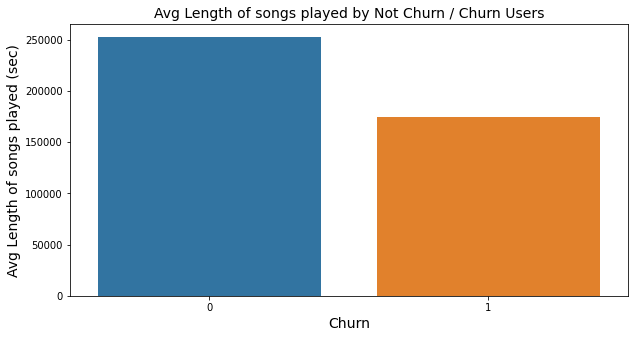

In [228]:
plt.figure(figsize =(10,5))

sb.barplot(x = 'churn_type', y='average_length', data=avglen4Group_df);
plt.xlabel('Churn', fontsize=14)
plt.ylabel('Avg Length of songs played (sec)', fontsize=14);
plt.title('Avg Length of songs played by Not Churn / Churn Users', fontsize=14);

- For Avg length of listening to the song, the un-churned users are way longer than churned

#### 3.  Churn rate VS userAgent used

In [314]:
usersys_func = udf(lambda x: x.split('(')[1].replace(";", " ").split(" ")[0])

In [312]:
usersys_df = df.withColumn('userAgent', usersys_func(df['userAgent']))
usersys_df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Windows', userId='30', Churn=0, hour='20'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='Windows', userId='9', Churn=0, hour='20')]

In [459]:
useragent_churn_df = usersys_df.select(['userId', 'userAgent', 'churn']).dropDuplicates()\
            .groupBy('userAgent').agg(count('userId').alias('num_users'), sum('churn').alias('num_churns'))

In [466]:
useragent_churn_df_pd = useragent_churn_df.toPandas()
useragent_churn_df_pd

,userAgent,num_users,num_churns
0,iPad,3,0
1,X11,17,5
2,iPhone,17,4
3,Macintosh,105,19
4,compatible,5,0
5,Windows,130,24


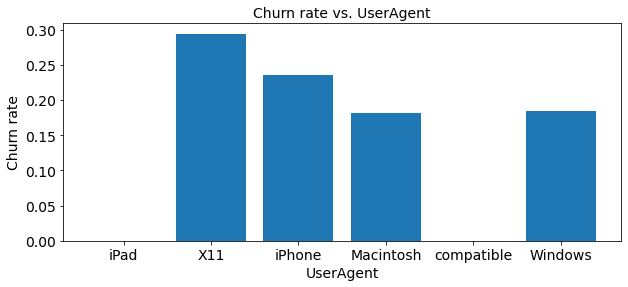

In [462]:
plt.figure(figsize=(10,4))
plt.bar(useragent_churn_df_pd['userAgent'], useragent_churn_df_pd['num_churns'] / useragent_churn_df_pd['num_users'])

plt.xlabel("UserAgent", fontsize=14)
plt.ylabel("Churn rate", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Churn rate vs. UserAgent", fontsize=14);

- We can see from the figure above that X11 have the most churn rate, also the iphone, 
- The agent service can take a look into those to improve the customer experience specificly

In [467]:
#from collections import defaultdict
#churn_useragent_dic = defaultdict(int)
#useragent_churn_pd_df = useragent_churn_df.toPandas()

#for i in useragent_churn_df.collect():
#    agent = i.userAgent
#    total_users = useragent_churn_pd_df.query('userAgent == @agent')['count(userId)'].sum()
#     churned_users = useragent_churn_pd_df.query('userAgent == @agent').query('Churn == 1').iloc[0,2]
#     print(churned_users / total_users)
    

#### 4. Based on `Page`, Difference between churn and no-churn uers

In [1006]:
useid_page_df = df.groupby(['userId']).pivot('page').count().toPandas().fillna(0)

In [283]:
useid_page_df.rename(columns={'Cancellation Confirmation': 'Churn'}, inplace = True)
useid_page_df

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3.0,4.0,8.0,0.0,0.0,5.0,0.0,2.0,20.0,5.0,387,7.0,0.0,3.0,0.0,1.0,6.0,21.0,2.0
1,100010,1.0,4.0,7.0,0.0,0.0,0.0,0.0,2.0,11.0,5.0,275,52.0,0.0,0.0,0.0,0.0,5.0,17.0,2.0
2,125,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,51,2.0,28.0,52.0,1.0,1.0,23.0,1.0,12.0,75.0,24.0,2111,0.0,1.0,12.0,0.0,0.0,21.0,100.0,0.0
4,124,7.0,74.0,118.0,0.0,0.0,41.0,6.0,23.0,176.0,59.0,4079,4.0,6.0,20.0,0.0,0.0,41.0,171.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,57,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,92,6.0,1.0,1.0,0.0,0.0,2.0,3.0,0.0
221,45,3.0,22.0,43.0,0.0,0.0,18.0,0.0,5.0,65.0,19.0,1484,13.0,4.0,15.0,0.0,1.0,13.0,67.0,4.0
222,200021,3.0,19.0,30.0,1.0,1.0,26.0,1.0,4.0,54.0,20.0,1227,11.0,2.0,9.0,0.0,1.0,35.0,55.0,3.0
223,119,1.0,4.0,5.0,0.0,0.0,0.0,1.0,3.0,11.0,2.0,173,9.0,1.0,3.0,0.0,0.0,1.0,7.0,2.0


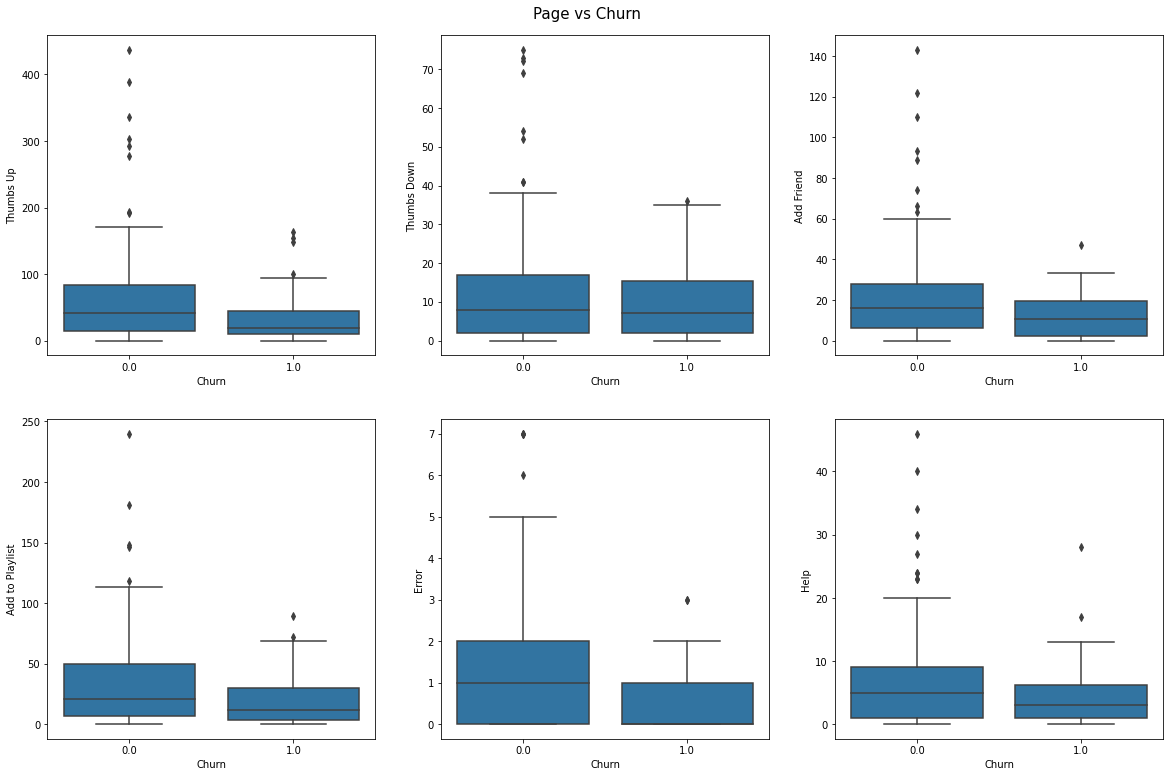

In [976]:
base_color = sb.color_palette()[0]

plt.figure(figsize = [20, 20]) 

plt.subplot(3, 3, 1)
sb.boxplot(data = useid_page_df, x = 'Churn', y = 'Thumbs Up',color = base_color)

plt.subplot(3, 3, 2)
sb.boxplot(data = useid_page_df, x = 'Churn', y = 'Thumbs Down',color = base_color)

plt.subplot(3, 3, 3)
sb.boxplot(data = useid_page_df, x = 'Churn', y = 'Add Friend',color = base_color)

plt.subplot(3, 3, 4)
sb.boxplot(data = useid_page_df, x = 'Churn', y = 'Add to Playlist',color = base_color)

plt.subplot(3, 3, 5)
sb.boxplot(data = useid_page_df, x = 'Churn', y = 'Error',color = base_color)

plt.subplot(3, 3, 6)
sb.boxplot(data = useid_page_df, x = 'Churn', y = 'Help',color = base_color)

plt.suptitle('Page vs Churn', fontsize =15, y=0.9);

By comparing the box plot of churn or not churn, Churn users:
- less likely to click thumbs up
- less likely to add friends
- less likely to add songs to playlist
- it doesn't necessarily mean that they have more errors and need more helps

# Feature Engineering
> Once familiarized with the data, build out the features find promising to train the model on. 

> To work with the full dataset,these steps are followed: 
> - Write a script to extract the necessary features from the smaller subset of data. 
> - Ensure that your script is scalable, using the best practices discussed in Lesson. 
> - Try your script on the full data set, debugging your script if necessary.

- `Page` is one of the important features. We want to take further look into the correlation matrix to see what is important to churn and not churn

In [977]:
corrMatrix = useid_page_df.corr()
corrMatrix

,Add Friend,Add to Playlist,Churn,Downgrade,Error,Help,Home,NextSong,Submit Downgrade,Thumbs Down,Thumbs Up
Add Friend,1.000000,0.929507,-0.180956,0.859250,0.667941,0.889177,0.934844,0.946730,0.461898,0.823676,0.902834
Add to Playlist,0.929507,1.000000,-0.151875,0.907773,0.681602,0.928972,0.970919,0.986427,0.453175,0.831258,0.939989
Churn,-0.180956,-0.151875,1.000000,-0.124208,-0.188287,-0.141573,-0.147023,-0.156110,-0.099973,-0.074668,-0.168105
Downgrade,0.859250,0.907773,-0.124208,1.000000,0.649847,0.873665,0.919348,0.929950,0.426362,0.836950,0.818785
Error,0.667941,0.681602,-0.188287,0.649847,1.000000,0.659052,0.699953,0.706660,0.316944,0.595875,0.670309
Help,0.889177,0.928972,-0.141573,0.873665,0.659052,1.000000,0.931481,0.941136,0.456135,0.788749,0.889711
Home,0.934844,0.970919,-0.147023,0.919348,0.699953,0.931481,1.000000,0.986356,0.500650,0.856326,0.916201
NextSong,0.946730,0.986427,-0.156110,0.929950,0.706660,0.941136,0.986356,1.000000,0.465063,0.851885,0.941196
Submit Downgrade,0.461898,0.453175,-0.099973,0.426362,0.316944,0.456135,0.500650,0.465063,1.000000,0.496730,0.412293
Thumbs Down,0.823676,0.831258,-0.074668,0.836950,0.595875,0.788749,0.856326,0.851885,0.496730,1.000000,0.778244


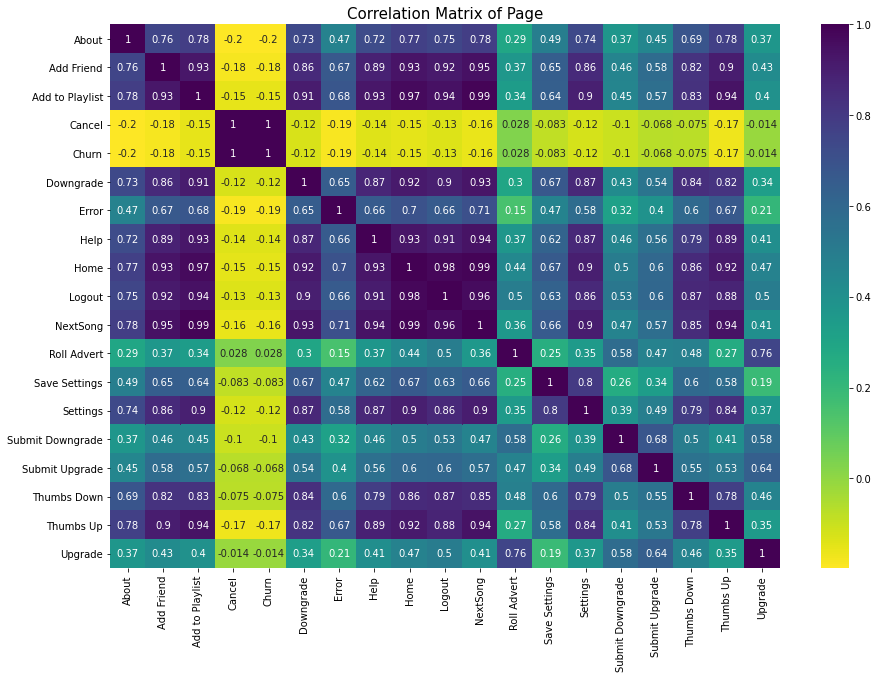

In [303]:
fig = plt.figure(figsize=(15, 10))
sb.heatmap(corrMatrix, annot=True,cmap = 'viridis_r')
plt.title('Correlation Matrix of Page', fontsize=15)
plt.show()

#### 18 Features for the model
A new feature table `df_features` created to include all important features for further analysis

#### 1. Remove un-related features of Page

In [978]:
df_features = df.groupby(['userId']).pivot('page').count().fillna(0)
df_features.withColumnRenamed('Cancellation Confirmation','Churn')
df_features = df_features.drop('About', 'Cancel', 'Login','Logout', 'Roll Advert', 'Submit Registration',  'Register', 'Save Settings')

In [979]:
df_features.head(2)

[Row(userId='200002', Add Friend=4, Add to Playlist=8, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, NextSong=387, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2),
 Row(userId='100010', Add Friend=4, Add to Playlist=7, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, NextSong=275, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2)]

#### 2. Total song length of the user listened

In [980]:
total_length = df.filter(df.page == 'NextSong').groupby(df.userId).agg(sum(df.length).alias('total_songlength'))
total_length.head(2)

[Row(userId='100010', total_songlength=66940.89735),
 Row(userId='200002', total_songlength=94008.87593999993)]

In [981]:
df_features = df_features.join(total_length, on=['userId'], how='inner')
df_features.head(2)

[Row(userId='100010', Add Friend=4, Add to Playlist=7, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, NextSong=275, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, total_songlength=66940.89735),
 Row(userId='200002', Add Friend=4, Add to Playlist=8, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, NextSong=387, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2, total_songlength=94008.87593999993)]

#### 3. Gender

In [982]:
gender_df = df.select('userId','gender').dropDuplicates()
#gender_df.head(2)
categories = gender_df.select('gender').distinct().rdd.flatMap(lambda x: x).collect()
#categories
exprs = [F.when(F.col('gender') == category, 1).otherwise(0).alias(category) for category in categories]
gender_df = gender_df.select('userId', *exprs)
gender_df.head(2)

[Row(userId='44', F=1, M=0), Row(userId='46', F=1, M=0)]

In [983]:
df_features = df_features.join(gender_df, on=['userId'], how='inner')
df_features.head(2)

[Row(userId='100010', Add Friend=4, Add to Playlist=7, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, NextSong=275, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, total_songlength=66940.89735, F=1, M=0),
 Row(userId='200002', Add Friend=4, Add to Playlist=8, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, NextSong=387, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2, total_songlength=94008.87593999993, F=0, M=1)]

#### 4. Number of days active

In [984]:
days = df.groupby('userId').agg(max(df.ts),(min(df.ts)))
days = days.withColumn('days_active', (col('max(ts)')-col('min(ts)')) / (60*60*24) )
days.head(2)

[Row(userId='100010', max(ts)=1542823952000, min(ts)=1539003534000, days_active=44217.80092592593),
 Row(userId='200002', max(ts)=1542324354000, min(ts)=1538393430000, days_active=45496.805555555555)]

In [985]:
df_features = df_features.join(days, on=['userId'], how='inner').drop('max(ts)','min(ts)')
df_features.head(2)

[Row(userId='100010', Add Friend=4, Add to Playlist=7, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, NextSong=275, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, total_songlength=66940.89735, F=1, M=0, days_active=44217.80092592593),
 Row(userId='200002', Add Friend=4, Add to Playlist=8, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, NextSong=387, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2, total_songlength=94008.87593999993, F=0, M=1, days_active=45496.805555555555)]

#### 5. Nnumber of days register the account

In [986]:
days_reg = df.groupby('userId').agg(max(df.registration),(max(df.ts)))
days_reg = days_reg.withColumn('days_register', (col('max(ts)')-col('max(registration)')) / (60*60*24) )
days_reg.head(2)
#days_reg['days_register'] = (days_reg['max(ts)'] - days_reg['max(registration)']) / (60*60*24)
#days_reg

[Row(userId='100010', max(registration)=1538016340000, max(ts)=1542823952000, days_register=55643.65740740741),
 Row(userId='200002', max(registration)=1536269906000, max(ts)=1542324354000, days_register=70074.62962962964)]

In [987]:
df_features = df_features.join(days_reg, on=['userId'], how='inner').drop('max(ts)','max(registration)')
df_features.head(2)
#df_features = df_features.join(days_reg.set_index('userId')).drop(['max(registration)','max(ts)'],axis=1)
#df_features

[Row(userId='100010', Add Friend=4, Add to Playlist=7, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, NextSong=275, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, total_songlength=66940.89735, F=1, M=0, days_active=44217.80092592593, days_register=55643.65740740741),
 Row(userId='200002', Add Friend=4, Add to Playlist=8, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, NextSong=387, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2, total_songlength=94008.87593999993, F=0, M=1, days_active=45496.805555555555, days_register=70074.62962962964)]

#### 6.  Final level of the user

In [988]:
final_level = df.groupby('userId', 'level').agg(max(df.ts).alias('finalTime')).sort("userId")
final_level.head(2)

[Row(userId='10', level='paid', finalTime=1542631788000),
 Row(userId='100', level='paid', finalTime=1543587349000)]

In [989]:
categories = final_level.select('level').distinct().rdd.flatMap(lambda x: x).collect()
exprs = [F.when(F.col('level') == category, 1).otherwise(0).alias(category) for category in categories]
final_level = final_level.select('userId', *exprs)
final_level.head(2)
#dummy_df = pd.get_dummies(final_level['level'])
#final_level = pd.concat([final_level,dummy_df],axis=1).drop('level',axis=1)
#final_level

[Row(userId='10', free=0, paid=1), Row(userId='100', free=0, paid=1)]

In [990]:
df_features = df_features.join(final_level, on=['userId'], how='inner').drop('finalTime')
df_features.head(2)
#df_features = df_features.join(final_level.set_index('userId')).drop('finalTime',axis=1)
#df_features

[Row(userId='100010', Add Friend=4, Add to Playlist=7, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, NextSong=275, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, total_songlength=66940.89735, F=1, M=0, days_active=44217.80092592593, days_register=55643.65740740741, free=1, paid=0),
 Row(userId='200002', Add Friend=4, Add to Playlist=8, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, NextSong=387, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2, total_songlength=94008.87593999993, F=0, M=1, days_active=45496.805555555555, days_register=70074.62962962964, free=1, paid=0)]

#### 7.  Fill 0 to any NaN value

In [991]:
df_features = df_features.fillna(0)

In [992]:
df_features.head(5)

[Row(userId='100010', Add Friend=4, Add to Playlist=7, Cancellation Confirmation=0, Downgrade=0, Error=0, Help=2, Home=11, NextSong=275, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, total_songlength=66940.89735, F=1, M=0, days_active=44217.80092592593, days_register=55643.65740740741, free=1, paid=0),
 Row(userId='200002', Add Friend=4, Add to Playlist=8, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, NextSong=387, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2, total_songlength=94008.87593999993, F=0, M=1, days_active=45496.805555555555, days_register=70074.62962962964, free=1, paid=0),
 Row(userId='200002', Add Friend=4, Add to Playlist=8, Cancellation Confirmation=0, Downgrade=5, Error=0, Help=2, Home=20, NextSong=387, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2, total_songlength=94008.87593999993, F=0, M=1, days_active=45496.805555

# Modeling
> Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine the winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, and F1 score as the metric to optimize.

In [993]:
#rename Cancellation Confirmation as label in df_features_label
df_features_label = df_features.withColumnRenamed('Cancellation Confirmation', 'label')
df_features_label.head(2)

[Row(userId='100010', Add Friend=4, Add to Playlist=7, label=0, Downgrade=0, Error=0, Help=2, Home=11, NextSong=275, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, total_songlength=66940.89735, F=1, M=0, days_active=44217.80092592593, days_register=55643.65740740741, free=1, paid=0),
 Row(userId='200002', Add Friend=4, Add to Playlist=8, label=0, Downgrade=5, Error=0, Help=2, Home=20, NextSong=387, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2, total_songlength=94008.87593999993, F=0, M=1, days_active=45496.805555555555, days_register=70074.62962962964, free=1, paid=0)]

In [994]:
#generate features table
df_features = df_features.drop('Cancellation Confirmation', 'userId')
df_features.head(2)

[Row(Add Friend=4, Add to Playlist=7, Downgrade=0, Error=0, Help=2, Home=11, NextSong=275, Settings=0, Submit Downgrade=0, Submit Upgrade=0, Thumbs Down=5, Thumbs Up=17, Upgrade=2, total_songlength=66940.89735, F=1, M=0, days_active=44217.80092592593, days_register=55643.65740740741, free=1, paid=0),
 Row(Add Friend=4, Add to Playlist=8, Downgrade=5, Error=0, Help=2, Home=20, NextSong=387, Settings=3, Submit Downgrade=0, Submit Upgrade=1, Thumbs Down=6, Thumbs Up=21, Upgrade=2, total_songlength=94008.87593999993, F=0, M=1, days_active=45496.805555555555, days_register=70074.62962962964, free=1, paid=0)]

In [995]:
#splitting the data
train, test = df_features_label.randomSplit([0.8, 0.2])

In [996]:
# instantiating vectorassembler for creating pipeline
vector_assembler = VectorAssembler(inputCols = df_features.columns, outputCol = 'Features')

In [997]:
# Scale each column for creating pipeline
scale_df = StandardScaler(inputCol = 'Features', outputCol='ScaledFeatures')

We choose to build three of the most common classification algorithms in PySpark API:
- Logistic Regression
- Random Forest
- Gradient Boosted Trees

In [998]:
def peformance(model, data, evaluation_metric):
    '''
    Input:
    model - pipeline object
    data - data want to evaluate
    evaluation_metric - the metric of the evaluations
    Output:
    score - f1 score
    confusion_matrix - confusion matrix
    '''
    # generate predictions
    evaluator = MulticlassClassificationEvaluator(metricName = evaluation_metric)
    predictions = model.transform(data)
    
    # get scores
    score = evaluator.evaluate(predictions)
    confusion_matrix = (predictions.groupby('label').pivot('prediction').count().toPandas())      
    
    return score, confusion_matrix

In [999]:
# logistic regression model
lr = LogisticRegression(featuresCol="ScaledFeatures", labelCol="label", maxIter=10, regParam=0.01)

# creating pipeline
pipeline_lr = Pipeline(stages=[vector_assembler, scale_df, lr])

# fitting the model
model_lr = pipeline_lr.fit(train)

In [1000]:
# performance 
score_lr, confusion_matrix_lr = peformance(model_lr, test, 'f1')
print('The f1 score for Logistic Regression model: {}'.format(score_lr))
confusion_matrix_lr

The f1 score for Logistic Regression model: 0.822229534087918


,label,0.0,1.0
0,0,59,3
1,1,10,8


In [1001]:
# Random Forest model
rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label", numTrees = 50,  featureSubsetStrategy='sqrt')

# creating pipeline
pipeline_rf = Pipeline(stages=[vector_assembler, scale_df, rf])

# fitting the model
model_rf = pipeline_rf.fit(train)

In [1002]:
# performance 
score_rf, confusion_matrix_rf = peformance(model_rf, test, 'f1')
print('The f1 score for Random Forest model: {}'.format(score_rf))
confusion_matrix_rf

The f1 score for Random Forest model: 0.9192307692307693


,label,0.0,1.0
0,0,62,NaN
1,1,6,12.0


In [1003]:
# Gradient Boosted Trees model
gbt = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label")

# creating pipeline
pipeline_gbt = Pipeline(stages=[vector_assembler, scale_df, gbt])

# fitting the model
model_gbt = pipeline_gbt.fit(train)

In [1004]:
# performance 
score_gbt, confusion_matrix_gbt = peformance(model_gbt, test, 'f1')
print('The f1 score for Gradient Boosted Trees model: {}'.format(score_gbt))
confusion_matrix_gbt

The f1 score for Gradient Boosted Trees model: 0.9336709177294323


,label,0.0,1.0
0,0,62,NaN
1,1,5,13.0


Gradient Boosted Trees model yields the best F1 score. 
- Because of the size of the dataset, the parameters obtained from these three models can't be applicable to the full 12 GB dataset. Therefore, hyperparameter tuning step was neglected.

#### Feature Importance
Let's look into our best model: Gradient boosting model to see what features contribute to the churn

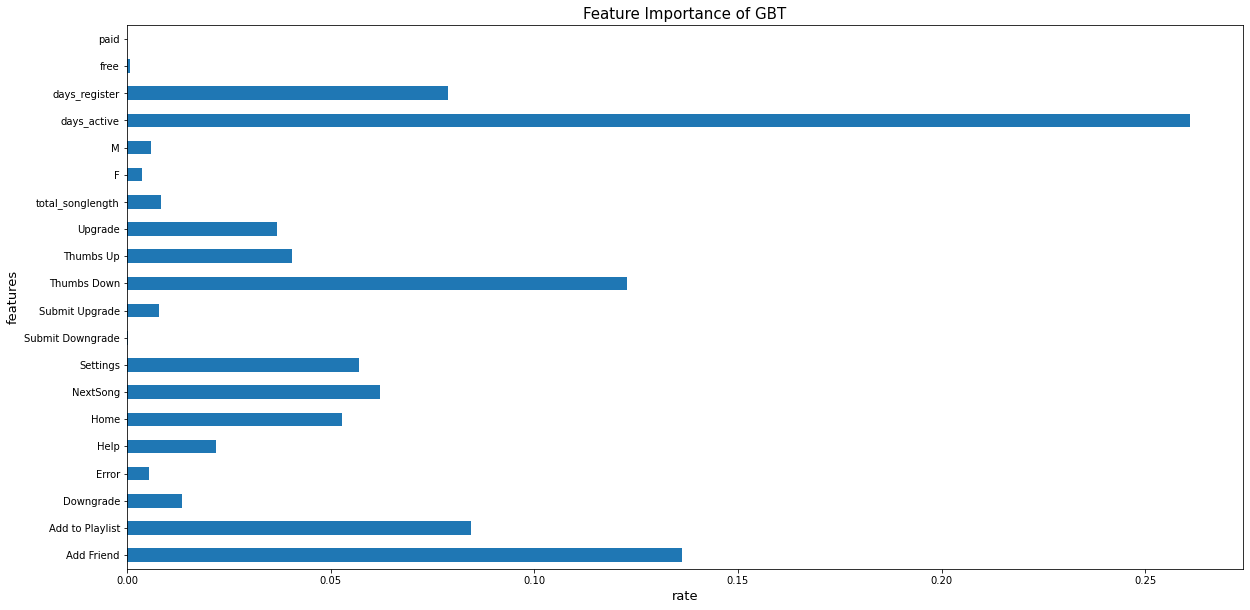

In [1005]:
plt.figure(figsize=[20,10])
feat_importances = pd.Series(np.array(model_gbt.stages[-1].featureImportances), index=df_features.columns)
feat_importances.plot(kind='barh')
plt.xlabel('rate',fontsize=13)
plt.ylabel('features',fontsize=13)
plt.title('Feature Importance of GBT', fontsize = 15);

- From the plot above, we can see that `days_active`, `days_register` and `Add to playlist` is really important features for predicting the churn in GBT models

# Conclusion
> This projectg gives us the idea of using pyspark to process large datasets from scratch to build the machine learning model for predicting churn. However, since we only have the mini-subset of the whole datasets, some of the features or predicting models have their limitations.